In [1]:
import tensorflow as tf
import numpy as np
import os
import PIL
import PIL.Image
import pathlib

# Old version

In [ ]:
# train_folder_path = pathlib.Path('D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-10/hei-train/left/')
# test_folder_path = pathlib.Path('D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-10/hei-test/left/')
# train_folder_path = pathlib.Path('D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-10/hei-train-v4/left/')
# test_folder_path = pathlib.Path('D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-10/hei-test-v2/left/')
train_folder_path = pathlib.Path('D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-10/augmented/usual_colors/hei-train-v1_v2/left/')
test_folder_path = pathlib.Path('D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-10/augmented/usual_colors/hei-test-v1/left/')

In [3]:
images = list(train_folder_path.glob('*/*.jpg'))
image_count = len(images)
print(image_count)

927


(128, 128)


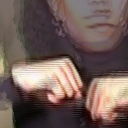

In [4]:
abitare = list(train_folder_path.glob('abitare/*'))
image = PIL.Image.open(str(abitare[0]))
print(image.size)
image

(104, 104)


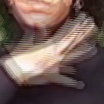

In [5]:
acqua = list(train_folder_path.glob('*acqua/*'))
image = PIL.Image.open(str(acqua[1]))
print(image.size)
image

In [6]:
images_sizes = [PIL.Image.open(image).size[0] for image in images]
images_sizes[:10]

[92, 108, 94, 108, 90, 90, 100, 100, 64, 70]

In [7]:
min(images_sizes)

40

In [8]:
video_shape = (576, 720)
video_area = video_shape[0]*video_shape[1]
images_areas = np.square(images_sizes)

In [9]:
area_ratio = np.round(images_areas/video_area, 3)
average_ratio = np.round(np.mean(area_ratio), 3)
average_ratio

0.025

In [10]:
np.round(np.mean(images_sizes))

100.0

In [12]:
train_batch_size = 32
img_height = 100
img_width = 100

In [13]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  train_folder_path,
  validation_split=0.2,
  subset="both",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=train_batch_size)

Found 927 files belonging to 10 classes.
Using 742 files for training.
Using 185 files for validation.


In [24]:
train_ds= tf.keras.utils.image_dataset_from_directory(
  train_folder_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=train_batch_size)

Found 927 files belonging to 10 classes.


In [14]:
class_names = train_ds.class_names

In [15]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_folder_path,
  image_size=(img_height, img_width),
  batch_size=100)

Found 79 files belonging to 10 classes.


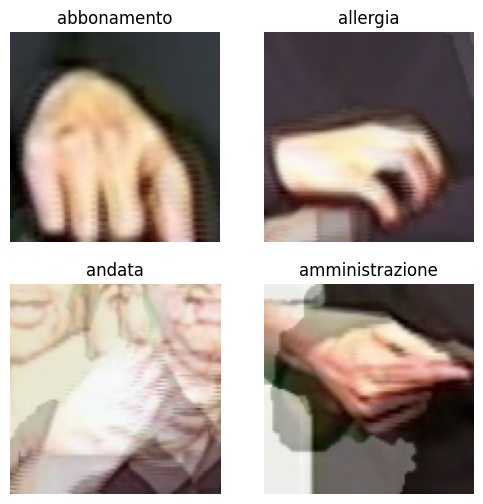

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

8.916056 254.82138


In [17]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [18]:
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
num_classes = len(class_names)

In [22]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [38]:
alexnet = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu'),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [23]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [39]:
alexnet.compile(
    optimizer='sgd',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']    
)

In [ ]:
model.fit(
  train_ds,
  epochs=8,
  validation_data=val_ds
)

Epoch 1/15


d:\Documentos\Polito\Thesis\Code\sign-language-recognition\thesis-venv\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


24/24 [==============================] - 6s 161ms/step - loss: 1.7605 - accuracy: 0.4151 - val_loss: 0.9751 - val_accuracy: 0.6649
Epoch 2/15
24/24 [==============================] - 4s 147ms/step - loss: 0.7256 - accuracy: 0.7318 - val_loss: 0.5095 - val_accuracy: 0.7730
Epoch 3/15
24/24 [==============================] - 4s 152ms/step - loss: 0.3839 - accuracy: 0.8774 - val_loss: 0.2577 - val_accuracy: 0.9405
Epoch 4/15
24/24 [==============================] - 4s 147ms/step - loss: 0.1697 - accuracy: 0.9488 - val_loss: 0.2255 - val_accuracy: 0.9459
Epoch 5/15
24/24 [==============================] - 4s 150ms/step - loss: 0.0718 - accuracy: 0.9852 - val_loss: 0.1529 - val_accuracy: 0.9622
Epoch 6/15
24/24 [==============================] - 4s 147ms/step - loss: 0.0371 - accuracy: 0.9919 - val_loss: 0.0368 - val_accuracy: 0.9892
Epoch 7/15
24/24 [==============================] - 4s 147ms/step - loss: 0.0118 - accuracy: 1.0000 - val_loss: 0.0251 - val_accuracy: 0.9892
Epoch 8/15
24/24 

In [25]:
model.fit(
  train_ds,
  epochs=8
)

Epoch 1/8
29/29 [==============================] - 5s 148ms/step - loss: 1.6860 - accuracy: 0.4790
Epoch 2/8
29/29 [==============================] - 4s 145ms/step - loss: 0.5392 - accuracy: 0.8123
Epoch 3/8
29/29 [==============================] - 4s 145ms/step - loss: 0.1858 - accuracy: 0.9579
Epoch 4/8
29/29 [==============================] - 4s 149ms/step - loss: 0.1327 - accuracy: 0.9644
Epoch 5/8
29/29 [==============================] - 4s 146ms/step - loss: 0.0377 - accuracy: 0.9946
Epoch 6/8
29/29 [==============================] - 4s 145ms/step - loss: 0.0135 - accuracy: 0.9989
Epoch 7/8
29/29 [==============================] - 4s 144ms/step - loss: 0.0053 - accuracy: 1.0000
Epoch 8/8
29/29 [==============================] - 4s 146ms/step - loss: 0.0037 - accuracy: 1.0000


In [40]:
import math
# Define configuration parameters
start_lr = 0.005
rampup_epochs = 10
exp_decay = 0.1

# Define the scheduling function
def schedule(epoch):
  def lr(epoch, start_lr, rampup_epochs, exp_decay):
    if epoch < rampup_epochs:
      return start_lr
    else:
      return start_lr * math.exp(-exp_decay * epoch)
  return lr(epoch, start_lr, rampup_epochs, exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(schedule, verbose=True)


alexnet.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[lr_callback]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.005.
Epoch 1/50


d:\Documentos\Polito\Thesis\Code\sign-language-recognition\thesis-venv\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


6/6 [==============================] - 8s 1s/step - loss: 2.3027 - accuracy: 0.0919 - val_loss: 2.3025 - val_accuracy: 0.0435 - lr: 0.0050

Epoch 2: LearningRateScheduler setting learning rate to 0.005.
Epoch 2/50
6/6 [==============================] - 6s 1s/step - loss: 2.3013 - accuracy: 0.0919 - val_loss: 2.3031 - val_accuracy: 0.0652 - lr: 0.0050

Epoch 3: LearningRateScheduler setting learning rate to 0.005.
Epoch 3/50
6/6 [==============================] - 6s 1s/step - loss: 2.3006 - accuracy: 0.1297 - val_loss: 2.3037 - val_accuracy: 0.1087 - lr: 0.0050

Epoch 4: LearningRateScheduler setting learning rate to 0.005.
Epoch 4/50
6/6 [==============================] - 6s 1s/step - loss: 2.2998 - accuracy: 0.1459 - val_loss: 2.3043 - val_accuracy: 0.0870 - lr: 0.0050

Epoch 5: LearningRateScheduler setting learning rate to 0.005.
Epoch 5/50
6/6 [==============================] - 7s 1s/step - loss: 2.3004 - accuracy: 0.1459 - val_loss: 2.3050 - val_accuracy: 0.0870 - lr: 0.0050

Epoc

KeyboardInterrupt: 

In [26]:
len(test_ds)

1

In [27]:
class_names

['abbonamento',
 'abitare',
 'acqua',
 'affitto',
 'allegare',
 'allergia',
 'ambulanza',
 'amministrazione',
 'ancona',
 'andata']

In [28]:
x, y = next(iter(test_ds))
predictions = np.argmax(model.predict(x), axis=-1)
labels = y

m = tf.keras.metrics.Accuracy()
m.update_state(predictions, labels)
m.result().numpy()

3/3 [==============================] - 0s 21ms/step


0.6708861

In [25]:
model.save("./saved_models/trainset_v4")

INFO:tensorflow:Assets written to: ./saved_models/trainset_v4\assets


INFO:tensorflow:Assets written to: ./saved_models/trainset_v4\assets


Label: abbonamento
Prediction: allergia


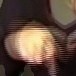




Label: abbonamento
Prediction: abbonamento


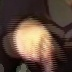




Label: abbonamento
Prediction: abbonamento


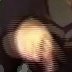




Label: abbonamento
Prediction: abbonamento


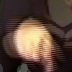




Label: abbonamento
Prediction: acqua


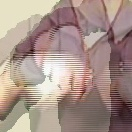




Label: abbonamento
Prediction: allegare


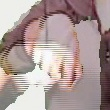




Label: abbonamento
Prediction: allergia


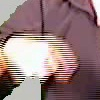




Label: abitare
Prediction: abitare


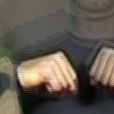




Label: abitare
Prediction: abitare


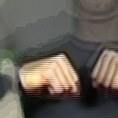




Label: abitare
Prediction: abitare


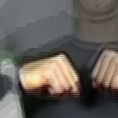




Label: abitare
Prediction: abitare


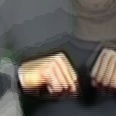




Label: abitare
Prediction: abitare


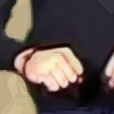




Label: abitare
Prediction: abitare


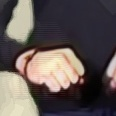




Label: abitare
Prediction: abitare


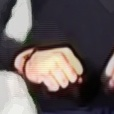




Label: abitare
Prediction: abitare


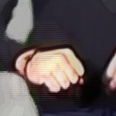




Label: acqua
Prediction: acqua


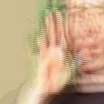




Label: acqua
Prediction: acqua


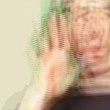




Label: acqua
Prediction: acqua


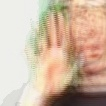




Label: acqua
Prediction: acqua


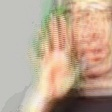




Label: acqua
Prediction: ambulanza


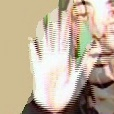




Label: acqua
Prediction: ambulanza


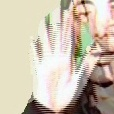




Label: acqua
Prediction: ambulanza


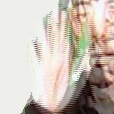




Label: acqua
Prediction: acqua


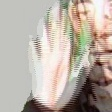




Label: affitto
Prediction: affitto


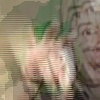




Label: affitto
Prediction: affitto


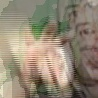




Label: affitto
Prediction: affitto


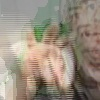




Label: affitto
Prediction: affitto


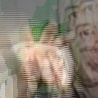




Label: affitto
Prediction: abbonamento


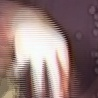




Label: affitto
Prediction: abbonamento


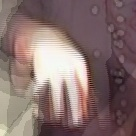




Label: affitto
Prediction: abbonamento


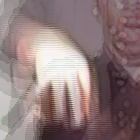




Label: affitto
Prediction: abbonamento


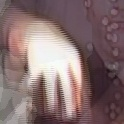




Label: allegare
Prediction: allegare


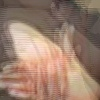




Label: allegare
Prediction: allegare


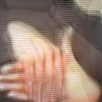




Label: allegare
Prediction: allegare


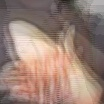




Label: allegare
Prediction: allegare


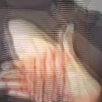




Label: allegare
Prediction: allegare


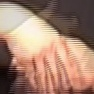




Label: allegare
Prediction: allegare


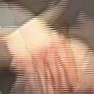




Label: allegare
Prediction: allegare


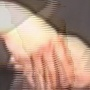




Label: allegare
Prediction: allegare


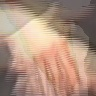




Label: allergia
Prediction: allergia


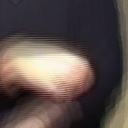




Label: allergia
Prediction: allergia


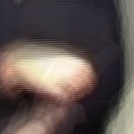




Label: allergia
Prediction: allergia


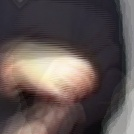




Label: allergia
Prediction: allergia


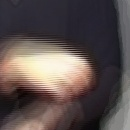




Label: allergia
Prediction: allergia


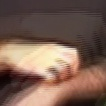




Label: allergia
Prediction: allergia


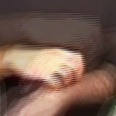




Label: allergia
Prediction: allergia


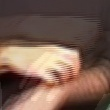




Label: allergia
Prediction: allergia


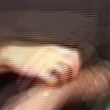




Label: ambulanza
Prediction: andata


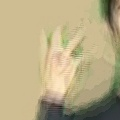




Label: ambulanza
Prediction: andata


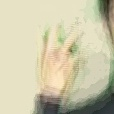




Label: ambulanza
Prediction: andata


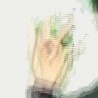




Label: ambulanza
Prediction: andata


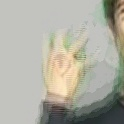




Label: ambulanza
Prediction: ambulanza


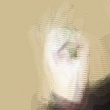




Label: ambulanza
Prediction: ambulanza


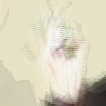




Label: ambulanza
Prediction: ambulanza


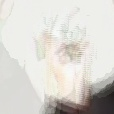




Label: ambulanza
Prediction: ambulanza


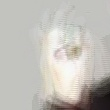




Label: amministrazione
Prediction: andata


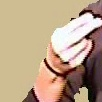




Label: amministrazione
Prediction: andata


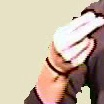




Label: amministrazione
Prediction: andata


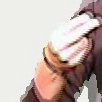




Label: amministrazione
Prediction: andata


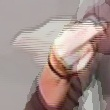




Label: amministrazione
Prediction: amministrazione


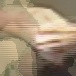




Label: amministrazione
Prediction: amministrazione


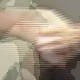




Label: amministrazione
Prediction: amministrazione


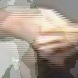




Label: amministrazione
Prediction: amministrazione


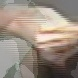




Label: ancona
Prediction: ancona


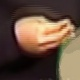




Label: ancona
Prediction: ancona


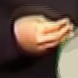




Label: ancona
Prediction: ancona


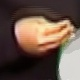




Label: ancona
Prediction: ancona


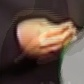




Label: ancona
Prediction: ancona


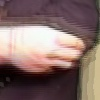




Label: ancona
Prediction: ancona


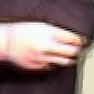




Label: ancona
Prediction: ancona


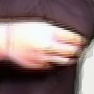




Label: ancona
Prediction: ancona


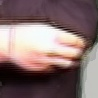




Label: andata
Prediction: amministrazione


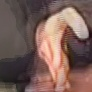




Label: andata
Prediction: amministrazione


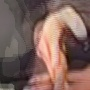




Label: andata
Prediction: amministrazione


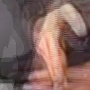




Label: andata
Prediction: amministrazione


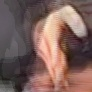




Label: andata
Prediction: allegare


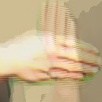




Label: andata
Prediction: ambulanza


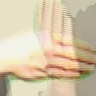




Label: andata
Prediction: andata


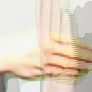




Label: andata
Prediction: ambulanza


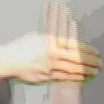

In [30]:
for path in test_folder_path.iterdir():
    for file in path.iterdir():
        print(f'Label: {path.name}')
        image = PIL.Image.open(file)
        image_array = tf.image.resize(image, [100,100])
        image_array = np.expand_dims(image_array, axis=0)
        print(f'Prediction: {class_names[int(np.argmax(model.predict(image_array, verbose=0)))]}')
        display(image)
        print('\n\n')


# New version

## Left model

In [5]:
hei_folder_path = pathlib.Path('D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-life/augmented/usual_colors/hei-videos-naturalwhite-v1/left/')
# hei_folder_path = pathlib.Path('D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-life/hei-videos/left/')

In [6]:
images = list(hei_folder_path.glob('*/*.jpg'))
image_count = len(images)
print(image_count)

165


(128, 128)


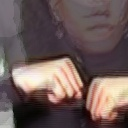

In [7]:
abitare = list(hei_folder_path.glob('abitare/*'))
image = PIL.Image.open(str(abitare[0]))
print(image.size)
image

(70, 70)


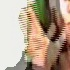

In [8]:
acqua = list(hei_folder_path.glob('*acqua/*'))
image = PIL.Image.open(str(acqua[1]))
print(image.size)
image

In [9]:
images_sizes = [PIL.Image.open(image).size[0] for image in images]
images_sizes[:10]

[128, 94, 108, 118, 114, 118, 138, 132, 152, 124]

In [10]:
min(images_sizes)

40

In [11]:
video_shape = (576, 720)
video_area = video_shape[0]*video_shape[1]
images_areas = np.square(images_sizes)

In [12]:
area_ratio = np.round(images_areas/video_area, 3)
average_ratio = np.round(np.mean(area_ratio), 3)
average_ratio

0.027

In [13]:
np.round(np.mean(images_sizes))

104.0

In [14]:
train_batch_size = 16
img_height = 100
img_width = 100

In [15]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  hei_folder_path,
  validation_split=0.3,
  subset="both",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=train_batch_size,
  shuffle=True)

Found 165 files belonging to 17 classes.
Using 116 files for training.
Using 49 files for validation.


In [16]:
val_batches = tf.data.experimental.cardinality(val_ds)
print(val_batches)

tf.Tensor(4, shape=(), dtype=int64)


In [17]:
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

In [18]:
class_names = train_ds.class_names

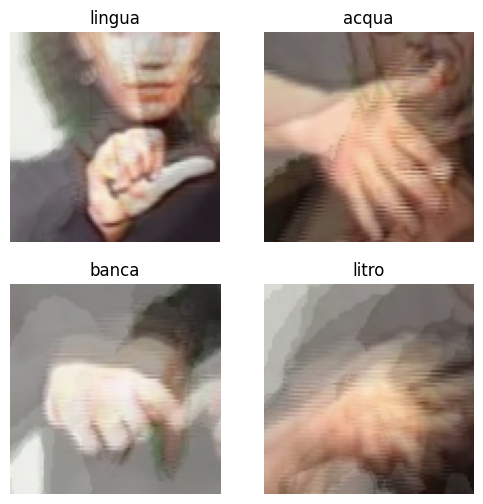

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
num_classes = len(class_names)

In [22]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [23]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [24]:
model.fit(
  train_ds,
  epochs=15,
  validation_data=val_ds
)

Epoch 1/15


d:\Documentos\Polito\Thesis\Code\sign-language-recognition\thesis-venv\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


8/8 [==============================] - 3s 98ms/step - loss: 2.8526 - accuracy: 0.0776 - val_loss: 2.8343 - val_accuracy: 0.0000e+00
Epoch 2/15
8/8 [==============================] - 1s 70ms/step - loss: 2.8012 - accuracy: 0.1121 - val_loss: 2.8493 - val_accuracy: 0.0588
Epoch 3/15
8/8 [==============================] - 1s 76ms/step - loss: 2.6729 - accuracy: 0.2672 - val_loss: 2.7685 - val_accuracy: 0.1176
Epoch 4/15
8/8 [==============================] - 1s 73ms/step - loss: 2.3899 - accuracy: 0.3190 - val_loss: 2.4200 - val_accuracy: 0.1765
Epoch 5/15
8/8 [==============================] - 1s 70ms/step - loss: 1.9238 - accuracy: 0.4224 - val_loss: 2.2447 - val_accuracy: 0.1765
Epoch 6/15
8/8 [==============================] - 1s 76ms/step - loss: 1.4785 - accuracy: 0.5603 - val_loss: 2.0793 - val_accuracy: 0.1765
Epoch 7/15
8/8 [==============================] - 1s 75ms/step - loss: 1.0543 - accuracy: 0.6638 - val_loss: 1.7181 - val_accuracy: 0.4706
Epoch 8/15
8/8 [==================

In [25]:
ds = train_ds.concatenate(val_ds)

In [26]:
AUTOTUNE = tf.data.AUTOTUNE

ds = ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
num_classes = len(class_names)

In [28]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [29]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [30]:
model.fit(
  ds,
  epochs=10
)

Epoch 1/10
10/10 [==============================] - 2s 81ms/step - loss: 2.8571 - accuracy: 0.0902
Epoch 2/10
10/10 [==============================] - 1s 62ms/step - loss: 2.7964 - accuracy: 0.2030
Epoch 3/10
10/10 [==============================] - 1s 65ms/step - loss: 2.6990 - accuracy: 0.2406
Epoch 4/10
10/10 [==============================] - 1s 63ms/step - loss: 2.4248 - accuracy: 0.2632
Epoch 5/10
10/10 [==============================] - 1s 63ms/step - loss: 1.9448 - accuracy: 0.3985
Epoch 6/10
10/10 [==============================] - 1s 60ms/step - loss: 1.5140 - accuracy: 0.4962
Epoch 7/10
10/10 [==============================] - 1s 70ms/step - loss: 0.9580 - accuracy: 0.7143
Epoch 8/10
10/10 [==============================] - 1s 67ms/step - loss: 0.6853 - accuracy: 0.8045
Epoch 9/10
10/10 [==============================] - 1s 66ms/step - loss: 0.4656 - accuracy: 0.8722
Epoch 10/10
10/10 [==============================] - 1s 68ms/step - loss: 0.3874 - accuracy: 0.8872


In [31]:
len(test_ds)

2

In [32]:
class_names

['abitare',
 'acqua',
 'affitto',
 'banca',
 'caldo',
 'casa',
 'cibo',
 'data',
 'freddo',
 'idle',
 'interprete',
 'inviare',
 'lingua',
 'litro',
 'mangiare',
 'posta',
 'telefono']

In [33]:
accuracy = tf.keras.metrics.Accuracy()

for x_batch, y_batch in test_ds:
    predictions = np.argmax(model.predict(x_batch), axis=-1)
    
    accuracy.update_state(y_batch, predictions)

final_accuracy = accuracy.result().numpy()
print("Test accuracy:", final_accuracy)

1/1 [==============================] - 0s 31ms/step
Test accuracy: 0.59375


In [ ]:
model.save("./saved_models/trainset_v4")

INFO:tensorflow:Assets written to: ./saved_models/trainset_v4\assets


INFO:tensorflow:Assets written to: ./saved_models/trainset_v4\assets


Label: banca
Prediction: banca


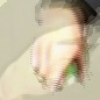




Label: litro
Prediction: litro


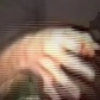




Label: inviare
Prediction: banca


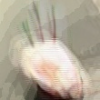




Label: affitto
Prediction: banca


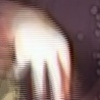




Label: freddo
Prediction: freddo


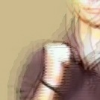




Label: idle
Prediction: idle


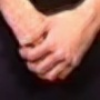




Label: affitto
Prediction: affitto


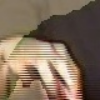




Label: freddo
Prediction: freddo


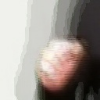




Label: data
Prediction: data


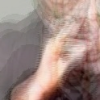




Label: interprete
Prediction: posta


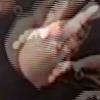




Label: interprete
Prediction: interprete


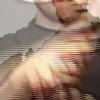




Label: freddo
Prediction: freddo


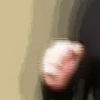




Label: lingua
Prediction: lingua


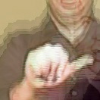




Label: litro
Prediction: banca


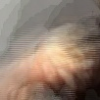




Label: posta
Prediction: posta


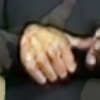




Label: affitto
Prediction: affitto


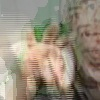




Label: lingua
Prediction: lingua


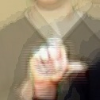




Label: data
Prediction: data


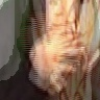




Label: data
Prediction: data


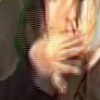




Label: idle
Prediction: idle


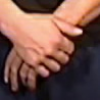




Label: caldo
Prediction: caldo


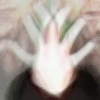




Label: interprete
Prediction: interprete


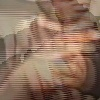




Label: banca
Prediction: banca


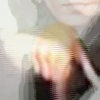




Label: lingua
Prediction: lingua


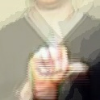




Label: idle
Prediction: idle


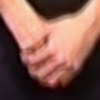




Label: posta
Prediction: posta


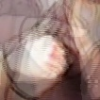




Label: inviare
Prediction: inviare


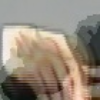




Label: affitto
Prediction: affitto


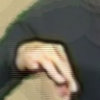




Label: interprete
Prediction: litro


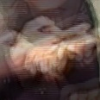




Label: mangiare
Prediction: mangiare


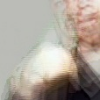




Label: caldo
Prediction: caldo


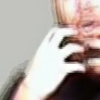




Label: acqua
Prediction: acqua


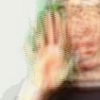




Label: mangiare
Prediction: mangiare


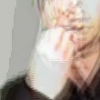




Label: telefono
Prediction: telefono


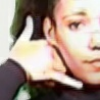




Label: mangiare
Prediction: mangiare


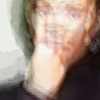




Label: caldo
Prediction: caldo


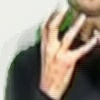




Label: inviare
Prediction: inviare


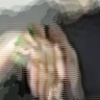




Label: abitare
Prediction: abitare


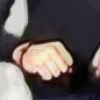




Label: litro
Prediction: litro


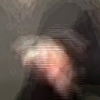




Label: interprete
Prediction: interprete


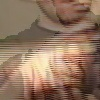




Label: acqua
Prediction: acqua


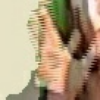




Label: data
Prediction: data


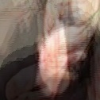




Label: posta
Prediction: posta


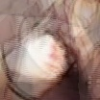




Label: banca
Prediction: banca


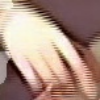




Label: mangiare
Prediction: cibo


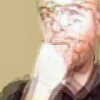




Label: acqua
Prediction: acqua


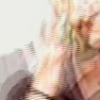




Label: affitto
Prediction: affitto


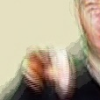




Label: caldo
Prediction: caldo


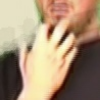




Label: casa
Prediction: casa


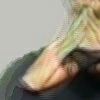




Label: casa
Prediction: casa


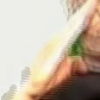




Label: telefono
Prediction: telefono


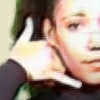




Label: telefono
Prediction: telefono


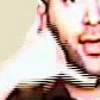




Label: inviare
Prediction: banca


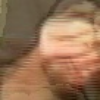




Label: inviare
Prediction: banca


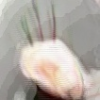




Label: interprete
Prediction: interprete


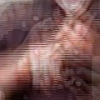




Label: litro
Prediction: litro


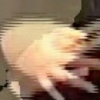




Label: cibo
Prediction: cibo


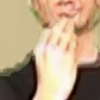




Label: interprete
Prediction: interprete


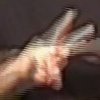




Label: posta
Prediction: posta


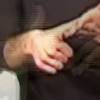




Label: lingua
Prediction: lingua


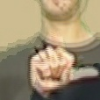




Label: lingua
Prediction: lingua


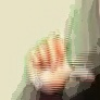




Label: inviare
Prediction: inviare


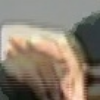




Label: acqua
Prediction: acqua


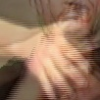




Label: telefono
Prediction: banca


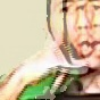




Label: mangiare
Prediction: mangiare


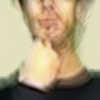




Label: acqua
Prediction: acqua


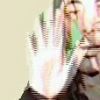




Label: mangiare
Prediction: mangiare


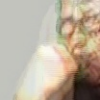




Label: casa
Prediction: casa


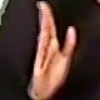




Label: abitare
Prediction: abitare


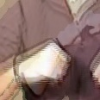




Label: acqua
Prediction: acqua


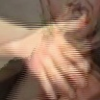




Label: litro
Prediction: affitto


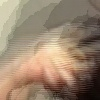




Label: acqua
Prediction: acqua


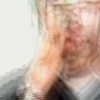




Label: inviare
Prediction: affitto


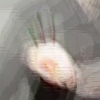




Label: interprete
Prediction: posta


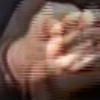




Label: idle
Prediction: idle


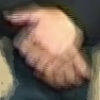




Label: inviare
Prediction: inviare


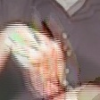




Label: lingua
Prediction: lingua


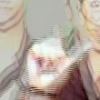




Label: posta
Prediction: posta


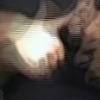




Label: freddo
Prediction: freddo


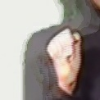




Label: idle
Prediction: idle


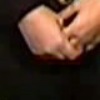




Label: interprete
Prediction: litro


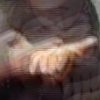




Label: banca
Prediction: banca


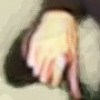




Label: affitto
Prediction: affitto


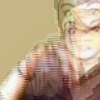




Label: freddo
Prediction: freddo


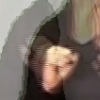




Label: freddo
Prediction: freddo


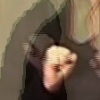




Label: acqua
Prediction: acqua


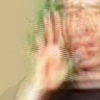




Label: lingua
Prediction: lingua


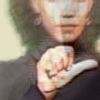




Label: idle
Prediction: idle


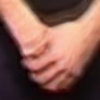




Label: interprete
Prediction: posta


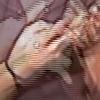




Label: interprete
Prediction: interprete


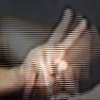




Label: data
Prediction: data


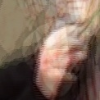




Label: posta
Prediction: posta


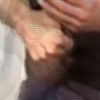




Label: data
Prediction: data


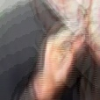




Label: data
Prediction: data


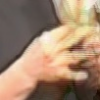




Label: posta
Prediction: posta


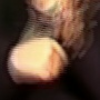




Label: acqua
Prediction: acqua


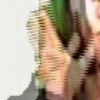




Label: affitto
Prediction: affitto


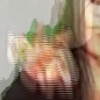




Label: affitto
Prediction: affitto


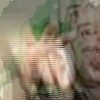




Label: idle
Prediction: idle


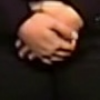




Label: abitare
Prediction: abitare


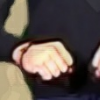




Label: lingua
Prediction: lingua


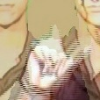




Label: caldo
Prediction: caldo


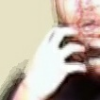




Label: posta
Prediction: posta


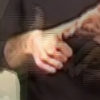




Label: idle
Prediction: idle


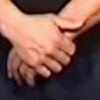




Label: litro
Prediction: litro


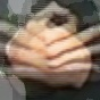




Label: interprete
Prediction: interprete


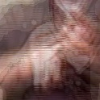




Label: banca
Prediction: banca


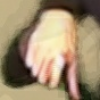




Label: caldo
Prediction: caldo


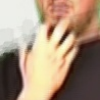




Label: inviare
Prediction: affitto


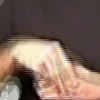




Label: abitare
Prediction: abitare


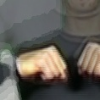




Label: affitto
Prediction: affitto


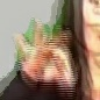




Label: cibo
Prediction: cibo


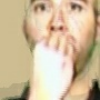




Label: cibo
Prediction: mangiare


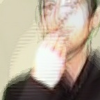




Label: casa
Prediction: casa


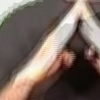




Label: cibo
Prediction: cibo


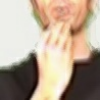




Label: abitare
Prediction: abitare


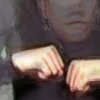




Label: freddo
Prediction: freddo


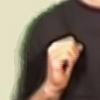




Label: lingua
Prediction: lingua


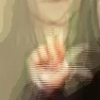




Label: inviare
Prediction: inviare


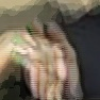




Label: banca
Prediction: banca


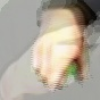




Label: acqua
Prediction: acqua


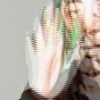




Label: lingua
Prediction: lingua


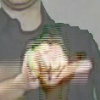




Label: freddo
Prediction: freddo


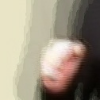




Label: acqua
Prediction: acqua


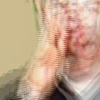




Label: data
Prediction: data


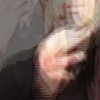




Label: acqua
Prediction: acqua


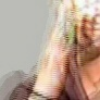




Label: lingua
Prediction: banca


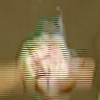




Label: inviare
Prediction: inviare


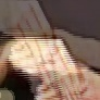

In [42]:
for images, labels in test_ds:
    # Faça as predições para o batch de imagens
    predictions = model.predict(images, verbose=0)
    predicted_classes = np.argmax(predictions, axis=-1)
    
    for i in range(len(images)):
        print(f'Label: {class_names[labels[i].numpy()]}')
        print(f'Prediction: {class_names[predicted_classes[i]]}')
        
        # Exiba a imagem
        img = tf.keras.preprocessing.image.array_to_img(images[i])
        display(img)
        
        print('\n\n')

## Right model

In [31]:
hei_folder_path = pathlib.Path('D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-life/augmented/usual_colors/hei-videos-naturalwhite-v1/right/')

In [32]:
images = list(hei_folder_path.glob('*/*.jpg'))
image_count = len(images)
print(image_count)

167


(134, 134)


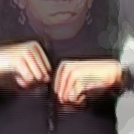

In [33]:
abitare = list(hei_folder_path.glob('abitare/*'))
image = PIL.Image.open(str(abitare[0]))
print(image.size)
image

(86, 86)


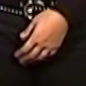

In [34]:
acqua = list(hei_folder_path.glob('*acqua/*'))
image = PIL.Image.open(str(acqua[1]))
print(image.size)
image

In [35]:
images_sizes = [PIL.Image.open(image).size[0] for image in images]
images_sizes[:10]

[134, 100, 106, 130, 138, 126, 150, 136, 132, 128]

In [36]:
min(images_sizes)

42

In [37]:
video_shape = (576, 720)
video_area = video_shape[0]*video_shape[1]
images_areas = np.square(images_sizes)

In [38]:
area_ratio = np.round(images_areas/video_area, 3)
average_ratio = np.round(np.mean(area_ratio), 3)
average_ratio

0.024

In [39]:
np.round(np.mean(images_sizes))

98.0

In [40]:
train_batch_size = 32
img_height = 100
img_width = 100

In [41]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  hei_folder_path,
  validation_split=0.3,
  subset="both",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=train_batch_size,
  shuffle=True)

Found 167 files belonging to 17 classes.
Using 117 files for training.
Using 50 files for validation.


In [42]:
class_names = train_ds.class_names

In [43]:
val_batches = tf.data.experimental.cardinality(val_ds)
print(val_batches)

tf.Tensor(2, shape=(), dtype=int64)


In [44]:
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

In [45]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

4
1
1


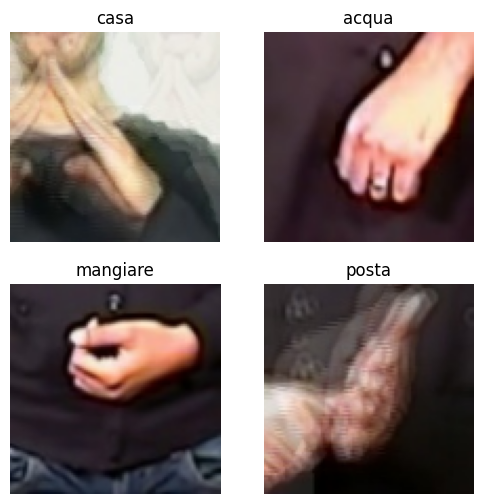

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [47]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [48]:
num_classes = len(class_names)

In [49]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [50]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [51]:
model.fit(
  train_ds,
  epochs=15,
  validation_data=val_ds
)

Epoch 1/15


d:\Documentos\Polito\Thesis\Code\sign-language-recognition\thesis-venv\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


4/4 [==============================] - 2s 196ms/step - loss: 2.8495 - accuracy: 0.0513 - val_loss: 2.8508 - val_accuracy: 0.1111
Epoch 2/15
4/4 [==============================] - 1s 141ms/step - loss: 2.7702 - accuracy: 0.2393 - val_loss: 2.8313 - val_accuracy: 0.1111
Epoch 3/15
4/4 [==============================] - 1s 145ms/step - loss: 2.6498 - accuracy: 0.2308 - val_loss: 2.7933 - val_accuracy: 0.0556
Epoch 4/15
4/4 [==============================] - 1s 140ms/step - loss: 2.3817 - accuracy: 0.2991 - val_loss: 2.6066 - val_accuracy: 0.0000e+00
Epoch 5/15
4/4 [==============================] - 1s 145ms/step - loss: 1.9259 - accuracy: 0.4615 - val_loss: 2.5587 - val_accuracy: 0.2222
Epoch 6/15
4/4 [==============================] - 1s 146ms/step - loss: 1.5059 - accuracy: 0.5214 - val_loss: 2.8309 - val_accuracy: 0.2778
Epoch 7/15
4/4 [==============================] - 1s 147ms/step - loss: 1.2131 - accuracy: 0.5983 - val_loss: 3.4077 - val_accuracy: 0.2778
Epoch 8/15
4/4 [===========

### Join training and validation datasets

In [103]:
ds = train_ds.concatenate(val_ds)

In [104]:
len(ds)

18

In [108]:
AUTOTUNE = tf.data.AUTOTUNE

ds = ds.cache().prefetch(buffer_size=AUTOTUNE)

In [109]:
num_classes = len(class_names)

In [110]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [111]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [112]:
model.fit(
  ds,
  epochs=15
)

Epoch 1/15
18/18 [==============================] - 3s 137ms/step - loss: 2.7850 - accuracy: 0.1259
Epoch 2/15
18/18 [==============================] - 2s 131ms/step - loss: 2.1318 - accuracy: 0.3370
Epoch 3/15
18/18 [==============================] - 2s 132ms/step - loss: 1.4059 - accuracy: 0.5667
Epoch 4/15
18/18 [==============================] - 2s 136ms/step - loss: 0.8909 - accuracy: 0.7111
Epoch 5/15
18/18 [==============================] - 2s 131ms/step - loss: 0.5337 - accuracy: 0.8611
Epoch 6/15
18/18 [==============================] - 2s 131ms/step - loss: 0.2957 - accuracy: 0.9056
Epoch 7/15
18/18 [==============================] - 2s 131ms/step - loss: 0.2325 - accuracy: 0.9296
Epoch 8/15
18/18 [==============================] - 2s 131ms/step - loss: 0.1565 - accuracy: 0.9537
Epoch 9/15
18/18 [==============================] - 2s 132ms/step - loss: 0.1311 - accuracy: 0.9704
Epoch 10/15
18/18 [==============================] - 2s 135ms/step - loss: 0.2193 - accuracy: 0.9463

In [113]:
len(test_ds)

4

In [114]:
class_names

['abitare',
 'acqua',
 'affitto',
 'banca',
 'caldo',
 'casa',
 'cibo',
 'data',
 'freddo',
 'idle',
 'interprete',
 'inviare',
 'lingua',
 'litro',
 'mangiare',
 'posta',
 'telefono']

In [115]:
accuracy = tf.keras.metrics.Accuracy()

for x_batch, y_batch in test_ds:
    predictions = np.argmax(model.predict(x_batch), axis=-1)
    
    accuracy.update_state(y_batch, predictions)

final_accuracy = accuracy.result().numpy()
print("Test accuracy:", final_accuracy)

1/1 [==============================] - 0s 45ms/step
Test accuracy: 0.9921875


In [ ]:
model.save("./saved_models/trainset_v4")

INFO:tensorflow:Assets written to: ./saved_models/trainset_v4\assets


INFO:tensorflow:Assets written to: ./saved_models/trainset_v4\assets


Label: telefono
Prediction: telefono


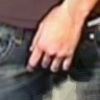




Label: abitare
Prediction: abitare


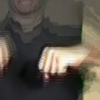




Label: cibo
Prediction: cibo


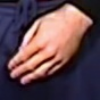




Label: casa
Prediction: casa


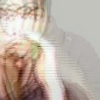




Label: idle
Prediction: idle


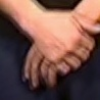




Label: banca
Prediction: banca


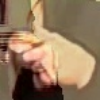




Label: acqua
Prediction: acqua


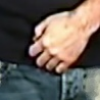




Label: caldo
Prediction: caldo


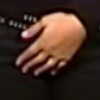




Label: caldo
Prediction: caldo


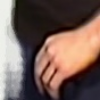




Label: banca
Prediction: banca


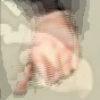




Label: posta
Prediction: posta


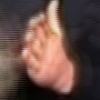




Label: mangiare
Prediction: mangiare


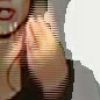




Label: affitto
Prediction: affitto


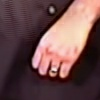




Label: freddo
Prediction: freddo


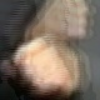




Label: idle
Prediction: idle


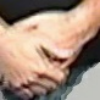




Label: affitto
Prediction: affitto


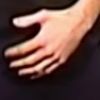




Label: freddo
Prediction: freddo


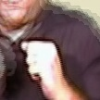




Label: litro
Prediction: litro


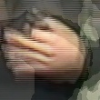




Label: data
Prediction: data


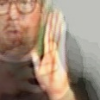




Label: interprete
Prediction: interprete


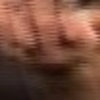




Label: inviare
Prediction: inviare


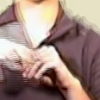




Label: freddo
Prediction: freddo


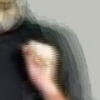




Label: litro
Prediction: litro


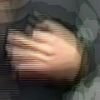




Label: mangiare
Prediction: mangiare


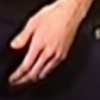




Label: mangiare
Prediction: mangiare


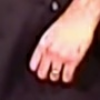




Label: affitto
Prediction: affitto


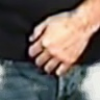




Label: inviare
Prediction: inviare


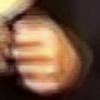




Label: data
Prediction: data


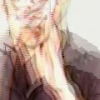




Label: data
Prediction: data


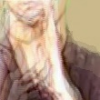




Label: interprete
Prediction: interprete


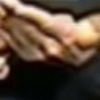




Label: caldo
Prediction: caldo


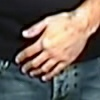




Label: inviare
Prediction: inviare


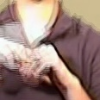




Label: banca
Prediction: banca


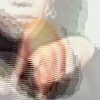




Label: acqua
Prediction: acqua


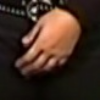




Label: idle
Prediction: idle


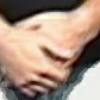




Label: posta
Prediction: posta


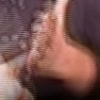




Label: inviare
Prediction: inviare


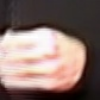




Label: telefono
Prediction: telefono


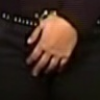




Label: affitto
Prediction: affitto


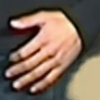




Label: interprete
Prediction: interprete


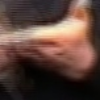




Label: mangiare
Prediction: mangiare


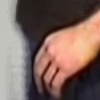




Label: caldo
Prediction: caldo


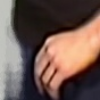




Label: acqua
Prediction: acqua


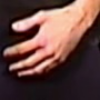




Label: posta
Prediction: posta


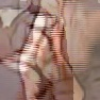




Label: telefono
Prediction: telefono


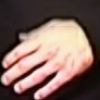




Label: lingua
Prediction: lingua


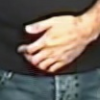




Label: lingua
Prediction: lingua


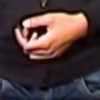




Label: banca
Prediction: banca


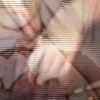




Label: posta
Prediction: posta


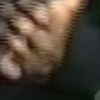




Label: casa
Prediction: casa


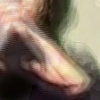




Label: casa
Prediction: casa


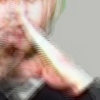




Label: mangiare
Prediction: mangiare


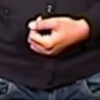




Label: telefono
Prediction: telefono


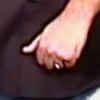




Label: posta
Prediction: posta


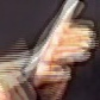




Label: lingua
Prediction: lingua


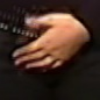




Label: inviare
Prediction: inviare


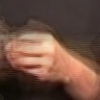




Label: inviare
Prediction: inviare


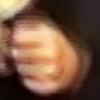




Label: posta
Prediction: posta


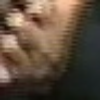




Label: cibo
Prediction: cibo


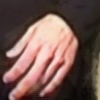




Label: interprete
Prediction: interprete


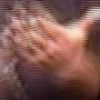




Label: telefono
Prediction: telefono


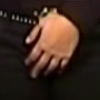




Label: lingua
Prediction: lingua


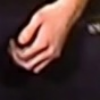




Label: lingua
Prediction: lingua


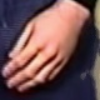




Label: inviare
Prediction: inviare


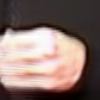




Label: acqua
Prediction: acqua


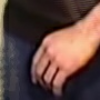




Label: mangiare
Prediction: mangiare


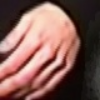




Label: mangiare
Prediction: mangiare


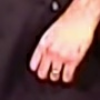




Label: acqua
Prediction: acqua


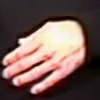




Label: posta
Prediction: posta


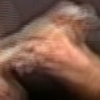




Label: casa
Prediction: casa


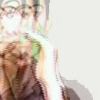




Label: abitare
Prediction: abitare


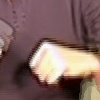




Label: acqua
Prediction: acqua


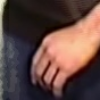




Label: mangiare
Prediction: mangiare


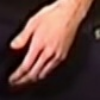




Label: acqua
Prediction: acqua


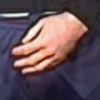




Label: inviare
Prediction: inviare


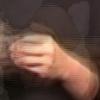




Label: interprete
Prediction: interprete


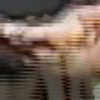




Label: idle
Prediction: idle


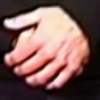




Label: lingua
Prediction: lingua


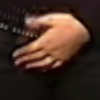




Label: lingua
Prediction: lingua


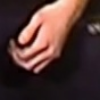




Label: telefono
Prediction: telefono


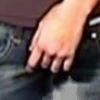




Label: freddo
Prediction: freddo


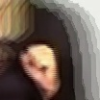




Label: idle
Prediction: idle


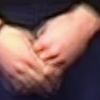




Label: interprete
Prediction: interprete


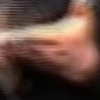




Label: banca
Prediction: banca


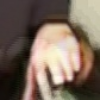




Label: affitto
Prediction: affitto


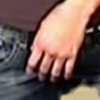




Label: freddo
Prediction: freddo


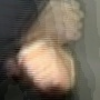




Label: freddo
Prediction: data


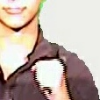




Label: acqua
Prediction: acqua


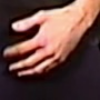




Label: lingua
Prediction: lingua


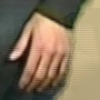




Label: idle
Prediction: idle


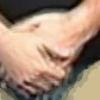




Label: interprete
Prediction: interprete


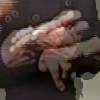




Label: interprete
Prediction: interprete


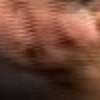




Label: data
Prediction: data


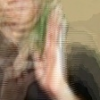




Label: telefono
Prediction: telefono


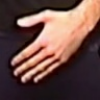




Label: data
Prediction: data


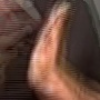




Label: freddo
Prediction: freddo


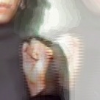




Label: posta
Prediction: posta


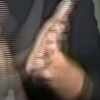




Label: acqua
Prediction: acqua


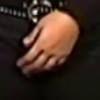




Label: affitto
Prediction: affitto


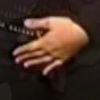




Label: affitto
Prediction: affitto


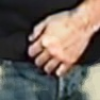




Label: idle
Prediction: idle


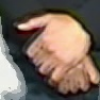




Label: abitare
Prediction: abitare


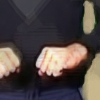




Label: lingua
Prediction: lingua


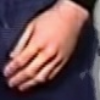




Label: caldo
Prediction: caldo


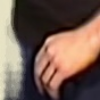




Label: telefono
Prediction: telefono


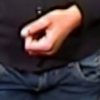




Label: interprete
Prediction: interprete


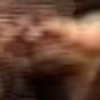




Label: litro
Prediction: litro


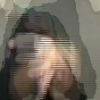




Label: inviare
Prediction: inviare


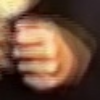




Label: banca
Prediction: banca


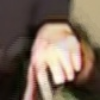




Label: casa
Prediction: casa


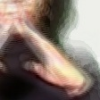




Label: inviare
Prediction: inviare


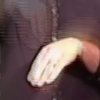




Label: abitare
Prediction: abitare


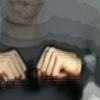




Label: affitto
Prediction: affitto


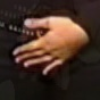




Label: cibo
Prediction: cibo


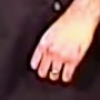




Label: cibo
Prediction: cibo


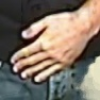




Label: casa
Prediction: casa


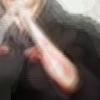




Label: cibo
Prediction: cibo


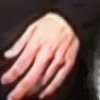




Label: abitare
Prediction: abitare


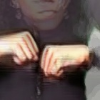




Label: idle
Prediction: idle


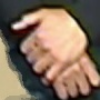




Label: lingua
Prediction: lingua


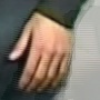




Label: inviare
Prediction: inviare


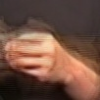




Label: banca
Prediction: banca


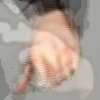




Label: acqua
Prediction: acqua


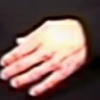




Label: litro
Prediction: litro


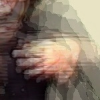




Label: freddo
Prediction: freddo


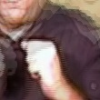




Label: acqua
Prediction: acqua


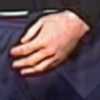




Label: data
Prediction: data


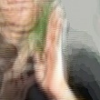




Label: acqua
Prediction: acqua


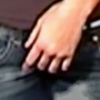

In [116]:
for images, labels in test_ds:
    # Faça as predições para o batch de imagens
    predictions = model.predict(images, verbose=0)
    predicted_classes = np.argmax(predictions, axis=-1)
    
    for i in range(len(images)):
        print(f'Label: {class_names[labels[i].numpy()]}')
        print(f'Prediction: {class_names[predicted_classes[i]]}')
        
        # Exiba a imagem
        img = tf.keras.preprocessing.image.array_to_img(images[i])
        display(img)
        
        print('\n\n')

# Combined model

## Dataset creation

In [53]:
from sklearn.model_selection import train_test_split

# Paths to the left and right hand folders
left_hand_folder = pathlib.Path("D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-life/augmented/usual_colors/hei-videos-naturalwhite-v1/left/")
right_hand_folder = pathlib.Path("D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-life/augmented/usual_colors/hei-videos-naturalwhite-v1/right/")

# Image size and batch size
img_height, img_width = 100, 100  # Adjust as needed
batch_size = 16

# Function to extract file paths, prefixes, and labels
def get_image_prefixes_and_labels(folder_path):
    image_data = []
    for label_folder in folder_path.iterdir():
        if label_folder.is_dir():
            label = label_folder.name  # Folder name as the label
            for image_file in label_folder.iterdir():
                if image_file.is_file():
                    image_data.append((image_file.stem, str(image_file), label))
    return image_data

# Get image paths, prefixes, and labels
left_images = get_image_prefixes_and_labels(left_hand_folder)
right_images = get_image_prefixes_and_labels(right_hand_folder)

# Create dictionaries to map prefixes to file paths and labels
left_dict = {prefix: (path, label) for prefix, path, label in left_images}
right_dict = {prefix: (path, label) for prefix, path, label in right_images}

# Match prefixes and align datasets with labels
aligned_data = []
for prefix in set(left_dict.keys()).union(right_dict.keys()):
    left_info = left_dict.get(prefix, (None, None))  # (path, label) or (None, None)
    right_info = right_dict.get(prefix, (None, None))
    aligned_data.append((left_info[0], right_info[0], left_info[1] or right_info[1]))

# Obter classes únicas
unique_labels = sorted(set(label for _, _, label in aligned_data))
label_to_index = {label: index for index, label in enumerate(unique_labels)}

# Split into training and validation sets
train_data, val_data = train_test_split(aligned_data, test_size=0.3, random_state=123)



# Function to preprocess images
def preprocess_image(image_path):
    if image_path is None:
        # Placeholder for missing images (e.g., black image or zeros)
        return tf.zeros((img_height, img_width, 3), dtype=tf.float32)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image

# Function to create a tf.data.Dataset
def create_dataset(data):
    def generator():
        for left_path, right_path, label in data:
            yield (preprocess_image(left_path), preprocess_image(right_path)), label_to_index[label]
    
    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            (
                tf.TensorSpec(shape=(img_height, img_width, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(img_height, img_width, 3), dtype=tf.float32),
            ),
            tf.TensorSpec(shape=(), dtype=tf.int32),  # Alterado para int32
        )
    )


In [54]:
# Create training and validation datasets
train_ds = create_dataset(train_data).batch(batch_size).shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = create_dataset(val_data).batch(batch_size).prefetch(tf.data.AUTOTUNE)

## Model

In [ ]:
# Define the base model structure
def create_model(num_classes):
    return tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

# Number of classes
num_classes = len(unique_labels)  # Adjust based on your dataset

# Create two models
model1 = create_model(num_classes)
model2 = create_model(num_classes)

# Define inputs for the functional model
input1 = tf.keras.Input(shape=(img_height, img_width, 3))  # Input for model1
input2 = tf.keras.Input(shape=(img_height, img_width, 3))  # Input for model2

# Get outputs from the two models
output1 = model1(input1)
output2 = model2(input2)

# Define a custom layer to handle dynamic averaging
# class DynamicAverage(tf.keras.layers.Layer):
#     def call(self, inputs):
#         output1, output2 = inputs
#         # Check if outputs are available (assume they are non-zero if available)
#         output1_available = tf.reduce_any(output1 != 0)
#         output2_available = tf.reduce_any(output2 != 0)
        
#         # Use available outputs
#         if output1_available and output2_available:
#             return (output1 + output2) / 2
#         elif output1_available:
#             return output1
#         elif output2_available:
#             return output2
#         else:
#             # Fallback if neither output is available (should not happen if inputs are valid)
#             return tf.zeros_like(output1)

class DynamicAverage(tf.keras.layers.Layer):
    def call(self, inputs):
        output1, output2 = inputs
        # Average only when both outputs are available; otherwise, use the available one
        return tf.where(
            tf.reduce_all(output1 != 0, axis=-1, keepdims=True) & 
            tf.reduce_all(output2 != 0, axis=-1, keepdims=True),
            (output1 + output2) / 2,
            tf.where(output1 != 0, output1, output2)
        )

# Apply the custom averaging layer
final_output = DynamicAverage()([output1, output2])

# Create the combined model
combined_model = tf.keras.Model(inputs=[input1, input2], outputs=final_output)

# Compile the combined model
combined_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training

combined_model.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=50
)


Epoch 1/50
15/15 [==============================] - 4s 172ms/step - loss: 2.8342 - accuracy: 0.0560 - val_loss: 2.8355 - val_accuracy: 0.0500
Epoch 2/50
15/15 [==============================] - 3s 156ms/step - loss: 2.8329 - accuracy: 0.0647 - val_loss: 2.8398 - val_accuracy: 0.0500
Epoch 3/50
15/15 [==============================] - 3s 171ms/step - loss: 2.8303 - accuracy: 0.0560 - val_loss: 2.8416 - val_accuracy: 0.0300
Epoch 4/50
15/15 [==============================] - 3s 159ms/step - loss: 2.8281 - accuracy: 0.0733 - val_loss: 2.8566 - val_accuracy: 0.0300
Epoch 5/50
15/15 [==============================] - 3s 170ms/step - loss: 2.8349 - accuracy: 0.0733 - val_loss: 2.8809 - val_accuracy: 0.0300
Epoch 6/50


KeyboardInterrupt: 

# Real time test

In [15]:
import cv2
import sys
sys.path.insert(1, './hand-tracking')
import handtracker

In [21]:
cap = cv2.VideoCapture(0)
tracker = handtracker.HandTracker(hei_frame_step=2, hei_max_duration=2, hei_overlap=0)
success = True
normalization_layer = tf.keras.layers.Rescaling(1./255)

while success == True:
    success, image = cap.read()
    if success:
        tracker.tracking(image, subpixel_layout='BGR')         

        hei_left, hei_right = tracker.image_averaging(save=False)
        if len(hei_left) > 0:
            print("Check")
            hei_left = tf.image.resize(hei_left, [104,104])
            hei_left = np.expand_dims(hei_left, axis=0)
            print(f'Prediction: {class_names[int(np.argmax(model.predict(hei_left, verbose=0)))]}')

Check
Prediction: andata
Check
Prediction: andata
Check
Prediction: andata
Check
Prediction: allegare
Check
Prediction: allegare
Check
Prediction: allegare
Check
Prediction: allegare
Check
Prediction: allegare
Check
Prediction: allegare
Check
Prediction: allegare
Check
Prediction: amministrazione
Check
Prediction: allegare
Check
Prediction: allegare
Check
Prediction: allegare
Check
Prediction: allegare


KeyboardInterrupt: 

In [22]:
cap.release()

In [26]:
class_names

['abbonamento',
 'abitare',
 'acqua',
 'affitto',
 'allegare',
 'allergia',
 'ambulanza',
 'amministrazione',
 'ancona',
 'andata']